<a href="https://colab.research.google.com/github/Xenofon-Chiotopoulos/HPC-Assignments-/blob/main/HPC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CPU implemintation


In [ ]:
import numpy as np
from scipy.sparse import coo_matrix

def function_g(x,y):
  return np.exp((x-0.5)**2+(y-0.5)**2)
def function_f(x,y):
  return -((2*x-1)**2+(2*y-1)**2+4)*np.exp((x-0.5)**2+(y-0.5)**2)

def discretise_cpu(N, function_f, function_g):
   
  nelements = 5 * N**2 - 16 * N + 16

  row_ind = np.empty(nelements, dtype=np.float64)
  col_ind = np.empty(nelements, dtype=np.float64)
  data = np.empty(nelements, dtype=np.float64)
  f = np.empty(N * N, dtype=np.float64)
  h = 1/(N+1)

  count = 0
  for i in range(N):
    for j in range(N):
      if i == 0 or i == N - 1 or j == 0 or j == N - 1:
        row_ind[count] = col_ind[count] = j * N + i
        data[count] =  1
        f[j * N + i] = function_g(i*h,j*h)
        count += 1
      else:
        row_ind[count : count + 5] = j * N + i
        col_ind[count] = j * N + i
        col_ind[count + 1] = j * N + i + 1
        col_ind[count + 2] = j * N + i - 1
        col_ind[count + 3] = (j + 1) * N + i
        col_ind[count + 4] = (j - 1) * N + i

        data[count] = (4*(N + 1)**2)
        data[count + 1 : count + 5] = (- (N + 1)**2)
        f[j * N + i] = function_f(i*h,j*h)
        count += 5
  return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f 

def u_exact(N):
  h = 1/(N+1)
  u_ext = np.zeros(shape = (N,N))
  for i in range(N):
    for j in range(N):
      u_ext[i,j] = function_g(i*h,j*h)
  return u_ext

def error(u_ext,u,N):
  e_rel = np.zeros(shape = (N,N))
  for i in range(N):
    for j in range(N):
      e_rel[i][j] = abs((u[i][j]-u_ext[i][j]))/abs(u_ext[i][j])
  e_max = np.mean(np.ravel(e_rel))
  return e_max

def visualise(N,u):
  fig = plt.figure(figsize=(8, 8))
  ax = fig.gca(projection='3d')
  ticks= np.linspace(0, 1, N)
  X, Y = np.meshgrid(ticks, ticks)
  surf = ax.plot_surface(X, Y, u, antialiased=True, cmap=cm.coolwarm)

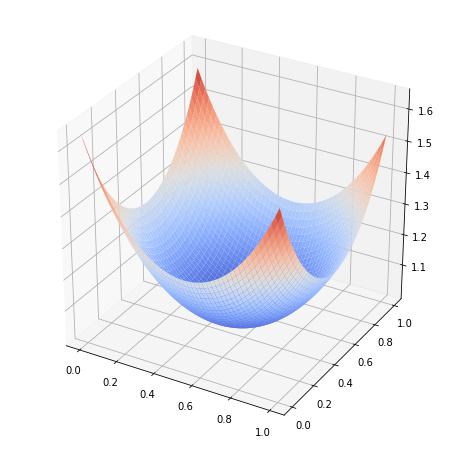

<function matplotlib.pyplot.show>

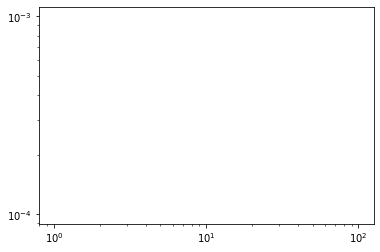

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from scipy.sparse.linalg import spsolve

N = 50
A, f = discretise_cpu(N, function_f, function_g)
sol = spsolve(A, f)

u = sol.reshape((N, N))


max_error = np.zeros(1000)
n_list = np.zeros(1000)

for i in range(10,N,100):
  exact = u_exact(i)
  A, f = discretise_cpu(i, function_f, function_g)
  solv = spsolve(A, f)
  u_i = solv.reshape((i, i))
  max_error[i] = error(exact,u_i,i)
  n_list[i] = i
max_error = max_error[max_error != 0]
n_list = n_list[n_list != 0]

visualise(N,u)
plt.show()
plt.loglog(n_list, max_error)
plt.show

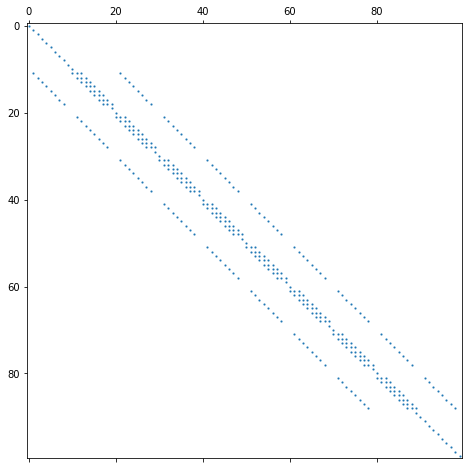

In [ ]:
plt.figure(figsize=(8, 8))
plt.spy(A, markersize=1)

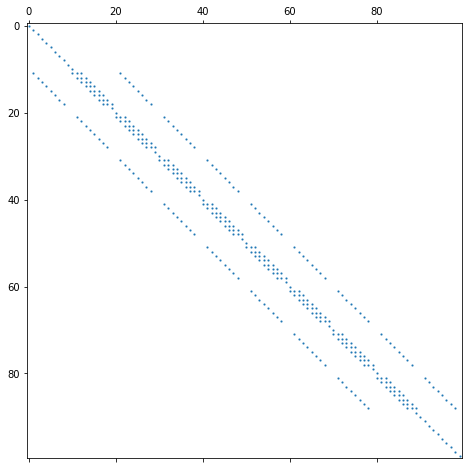

In [ ]:
plt.figure(figsize=(8, 8))
plt.spy(A[:1000, :1000], markersize=1)

In [ ]:
nbytes = A.data.nbytes + A.indices.nbytes + A.indptr.nbytes
print(f"The matrix A uses {round(nbytes / 1024**2, 2)} MB Ram.")

The matrix A uses 0.0 MB Ram.


##CPU iteration

In [ ]:
def create_grid(N, function_f, function_g):
  u = np.empty((N+2) ** 2, dtype=np.float32)
  f = np.empty((N+2) ** 2, dtype=np.float32)
  h = 1/(N+1)
  for i in range(N+2):
    for j in range(N+2):
      if i == 0 or i == N + 1 or j == 0 or j == N + 1:
        f[j * (N+2) + i] = 0
        u[j * (N+2) + i] = function_g(i*h,j*h)
      else:
        f[j * (N+2) + i] = function_f(i*h,j*h)
        u[j * (N+2) + i] = 0  
  return f, u
  
def iterate_cpu(f, u, N):
  v = u
  h = 1/(N+1)
  for j in range(1,N+1):
    for i in range(1,N+1):
      v[i+(N+2)*j] = (1/4)*((h**2)*f[i+(N+2)*j] + u[i+1+(N+2)*j] + u[i-1+(N+2)*j] + u[i+(N+2)*(j-1)] + u[i+(N+2)*(j+1)])
  u = v
  return u

def iterate_cpu_iter(iteration,f_cpu, u_cpu, N):
  ans = 0
  for i in range(iteration):
    ans =iterate_cpu(f_cpu, u_cpu, N)
  return ans

def error_cpu(N,itr):
  exact_error = u_exact(N)
  err_array = np.zeros(shape=((N+2)**2,(N+2)**2))
  for i in range(10,N,10):
    f_cpu, u_cpu = create_grid(i, function_f, function_g)
    for j in range(100,itr,100):
      cpu_err = iterate_cpu_iter(j,f_cpu, u_cpu, i)
      cpu_err = cpu_err.reshape((i+2),(i+2))
      x = error(exact_error,cpu_err,i)
      i_ = int(i/10)
      j_ = int(j/10)
      err_array[i_][j_] = x 
  return err_array

[0.11352424 0.11337049 0.10882724 0.06967155]


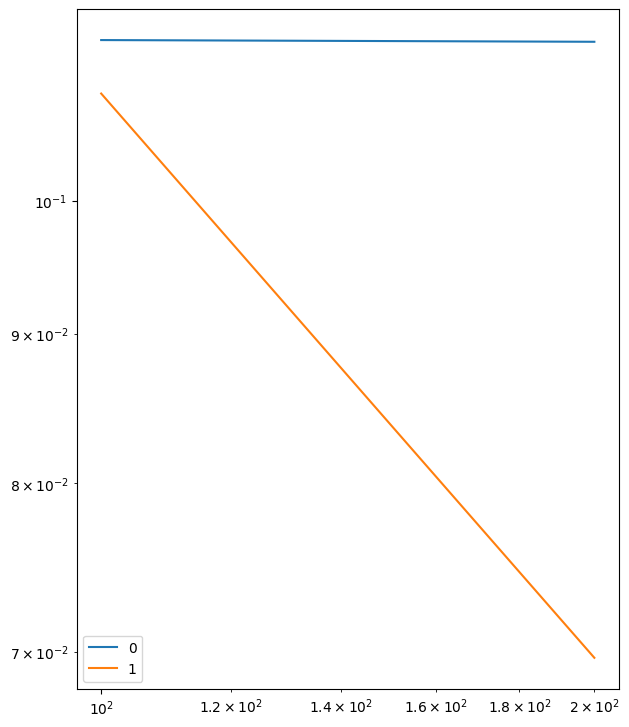

In [ ]:
from matplotlib.pyplot import figure
a = 30
b = 300

y = error_cpu(a,b)
y = y[y != 0]
print(y)
y = y.reshape(2,2)
index = np.array([i for i in range(100,b,100)])
figure(figsize=(7,9), dpi=100)
for j in range(int(int(a-1)/10)):
  plt.loglog(index, y[j],label=j)
  
plt.legend()
plt.show()

In [ ]:
N = 50

In [ ]:
f_cpu, u_cpu = create_grid(N, function_f, function_g)
testing = iterate_cpu_iter(100,f_cpu, u_cpu, N)
testing = testing.reshape((N+2),(N+2))
print(testing.shape)
o = u_exact(N+2)
print(o.shape)
error(o,testing,N)

(52, 52)
(52, 52)


0.4848639436393524

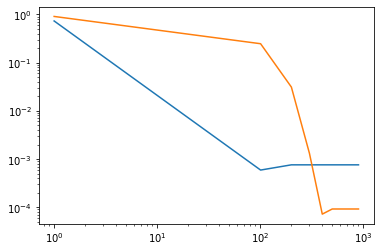

In [ ]:
for N in range(10,50,20):
  f_cpu, u_cpu = create_grid(N, function_f, function_g)
  error_array = np.zeros(1001)
  for j in range(1,1001,100):    
    testing = iterate_cpu_iter(j,f_cpu, u_cpu, N)
    error_array[j] += error(u_exact(N),testing.reshape(N+2,N+2),N)
  error_array = error_array[error_array != 0]
  plot_list = np.array([i for i in range(1,1001,100)])
  plt.loglog(plot_list, error_array)
plt.show()

In [ ]:
N=100
f_cpu, u_cpu = create_grid(N, function_f, function_g)
print(f_cpu, u_cpu)
x = iterate_cpu_iter(100, f_cpu, u_cpu, N)
x = x.reshape(N+2,N+2)
x.shape

[0. 0. 0. ... 0. 0. 0.] [1.6487212 1.6326379 1.6170284 ... 1.6170284 1.6326379 1.6487212]


(102, 102)

In [ ]:
f_cpu, u_cpu = create_grid(4, function_f, function_g)
ans = iterate_cpu_iter(100, f_cpu, u_cpu, N)
ans = ans.reshape((N+2),(N+2))
visualise((N+2),ans)
error(u_exact(N),ans,N)

IndexError: ignored

##GPU iteration

In [ ]:
import numba
from numba import cuda, njit, prange
import math

In [ ]:

def create_grid(N, function_f, function_g):
  h = 1/(N+1)
  for i in range(N+2):
    for j in range(N+2):
      if i == 0 or i == N + 1 or j == 0 or j == N + 1:
        f[j * (N+2) + i] = 0
        u[j * (N+2) + i] = function_g(i*h,j*h)
      else:
        f[j * (N+2) + i] = function_f(i*h,j*h)
        u[j * (N+2) + i] = 0  
  return f, u

In [ ]:
v = np.empty((N+2) ** 2, dtype=np.float32)
TPB = 16
BPG = ((N+2)+TPB-1) // TPB
@cuda.jit()
def iterate(f, u, v):
  #local_u = cuda.shared.array(shape=(TPB), dtype=numba.float32)
  #local_f = cuda.shared.array(shape=(TPB), dtype=numba.float32)
  #local_v = cuda.shared.array(shape=(TPB), dtype=numba.float32)
  
  local_u = u
  local_f = f
  local_v = v
  
  tx = cuda.threadIdx.x
  bx = cuda.blockIdx.x
  cuda.syncthreads()

  j = TPB*bx + tx
  if j == 0 or j == N+1:
    return
  else:
    local_v = local_u
    h = 1/(N+1)
    for i in range(1,N+1):
      local_v[i+(N+2)*j] = 0.25*((h**2)*local_f[i+(N+2)*j] + local_u[i+1+(N+2)*j] + local_u[i-1+(N+2)*j] + local_u[i+(N+2)*(j-1)] + local_u[i+(N+2)*(j+1)])
    cuda.syncthreads()
    local_u = local_v    

In [ ]:
N = 100
f = np.empty((N+2) ** 2, dtype=np.float64)
u = np.empty((N+2) ** 2, dtype=np.float64)
f_gpu, u_gpu = create_grid(N, function_f, function_g)
local_u = cuda.to_device(u)
local_f = cuda.to_device(f)
local_v = cuda.to_device(v)
for i in range(1000):
  iterate[(BPG,1),(TPB,1)](local_f, local_u, local_v)

ary = np.empty(shape=local_u.shape, dtype=local_u.dtype)
local_u.copy_to_host(ary)
local_u = ary

CudaSupportError: ignored

In [ ]:
local_u = local_u.reshape((N+2),(N+2))
print(local_u)

In [ ]:
visualise((N+2),local_u)
error(u_exact(N),local_u,N)

##Iterative CPU implemintation

In [ ]:
import numba
from numba import cuda
import math

In [ ]:
def discretise(N, function_f, function_g):
   
  nelements = 4*(N-1) + 4*(N-2)**2
  
  row_ind = np.empty(nelements, dtype=np.float64)
  col_ind = np.empty(nelements, dtype=np.float64)
  data = np.empty(nelements, dtype=np.float64)
  f = np.empty(N * N, dtype=np.float64)
  h = 1/(N+1)

  count = 0
  for i in range(N):
    for j in range(N):
      if i == 0 or i == N - 1 or j == 0 or j == N - 1:
        row_ind[count] = col_ind[count] = j * N + i
        data[count] =  1
        f[j * N + i] = 0
        count += 1
      else:
        row_ind[count : count + 4] = j * N + i
        col_ind[count + 0] = j * N + i + 1
        col_ind[count + 1] = j * N + i - 1
        col_ind[count + 2] = (j + 1) * N + i
        col_ind[count + 3] = (j - 1) * N + i

        data[count : count + 4] = 0.25
        f[j * N + i] = (h**2)*function_f(i*h,j*h)*0.25
        count += 4
   
  return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f 

def init(N):
  h = 1/(N+1)
  u = np.zeros(N*N)
  for i in range(N):
    for j in range(N):
      if i == 0 or i == N-1 or j == 0 or j == N-1:
        u[j*N + i] = function_g(i*h,j*h)
      else:
        u[j*N+i] = 0
  return u.astype('float32')

In [ ]:
N=4
elements = 4*(N-1) + 4*(N-2)**2
y = np.zeros(N**2, dtype=np.float32)
block_size = 512
threadsperblock = (N**2 + block_size - 1) // block_size

@numba.cuda.jit()
def csr_matvec_gpu(data, indices, indptr, shape, u, f, y, conv):
  """Evaluates the matrix-vector product with a CSR matrix."""
  #Leading all the local arrays needed 
  local_data = cuda.shared.array((elements,1), numba.int32)
  local_indices = cuda.shared.array((elements,1), numba.int32)
  local_indptr = cuda.shared.array((elements,1), numba.float32)
  local_f = cuda.shared.array((block_size,1), numba.float32)
  local_u = cuda.shared.array((block_size,1), numba.float32)
  local_y = cuda.shared.array((block_size,1), numba.float32)


  #initilization A

  local_data = data
  local_indices = indices
  local_indptr = indptr

  #initilization vectors
  
  local_f = f
  local_u = u
  local_y = y

  #Thread
  tx = cuda.threadIdx.x

  #blocks 
  bx = cuda.blockIdx.x

  cuda.syncthreads()

  row = block_size*bx + tx
  # Get the rows and columns    
    
  for i in range(conv):
    if row < N*N:
      dummy = 0.
      col_start = local_indptr[row]
      col_end = local_indptr[row + 1]
      for col_index in range(col_start, col_end):
        dummy += local_data[col_index] * local_u[indices[col_index]]
      local_y[row] = dummy + local_f[row]
      cuda.syncthreads()
      local_u = local_y

In [ ]:
p = init(N)
A, f = discretise(N, function_f, function_g)

In [ ]:
csr_matvec_gpu[(threadsperblock,1),(block_size,1)](A.data, A.indices, A.indptr, u.shape[0], p, f, y, 10000)

In [ ]:
y

array([1.6487212, 1.4049476, 1.2969301, 1.2969301, 1.4049476, 1.1996373,
       1.1073442, 1.105171 , 1.2969301, 1.1073442, 1.0221485, 1.0202013,
       1.2969301, 1.105171 , 1.0202013, 1.0202013], dtype=float32)

0.029201408519905984


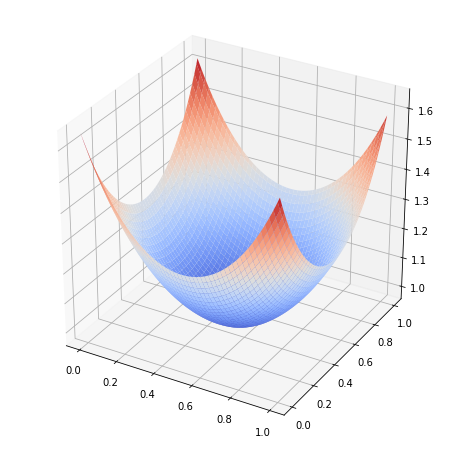

In [ ]:
p = p.reshape(N,N)
y = y.reshape(N,N)
print(error( u_exact(N),y, N))
visualise(N,y)

##GPU dense


In [ ]:
import numpy as np
from numba import cuda, types, float32
@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    TPB = N

    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

# This part is for initializing everything
M = 128
N = 32


#a = np.arange(M*N).reshape(M,N).astype(np.float32)
#b = np.arange(M*N).reshape(N,M).astype(np.float32)
a = np.array([1,2,3,4]).reshape(2,2).astype(np.float32)
b = np.array([4,5]).reshape(2,1).astype(np.float32)
c = np.zeros((2, 1)).astype(np.float32)

d_a = cuda.to_device(a)
d_b = cuda.to_device(b)
d_c = cuda.to_device(c)

block_size = (N,N)
grid_size = (int(M/N),int(M/N))

fast_matmul[grid_size,block_size](d_a, d_b, d_c)
c = d_c.copy_to_host()
print(c)

[[14.]
 [32.]]


In [ ]:
TPB = 16

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=np.float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=np.float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

NameError: ignored

##Testing area

In [ ]:
import numba
from numba import cuda
import math

def discretise(N, function_f, function_g):
   
  nelements = 4*(N-1) + 4*(N-2)**2
  
  row_ind = np.empty(nelements, dtype=np.float64)
  col_ind = np.empty(nelements, dtype=np.float64)
  data = np.empty(nelements, dtype=np.float64)
  f = np.empty(N * N, dtype=np.float64)
  h = 1/(N+1)

  count = 0
  for i in range(N):
    for j in range(N):
      if i == 0 or i == N - 1 or j == 0 or j == N - 1:
        row_ind[count] = col_ind[count] = j * N + i
        data[count] =  1
        f[j * N + i] = 0
        count += 1
      else:
        row_ind[count : count + 4] = j * N + i
        col_ind[count + 0] = j * N + i + 1
        col_ind[count + 1] = j * N + i - 1
        col_ind[count + 2] = (j + 1) * N + i
        col_ind[count + 3] = (j - 1) * N + i

        data[count : count + 4] = 0.25
        f[j * N + i] = (h**2)*function_f(i*h,j*h)*0.25
        count += 4
   
  return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f 

def init(N):
  h = 1/(N+1)
  u = np.zeros(N*N)
  for i in range(N):
    for j in range(N):
      if i == 0 or i == N-1 or j == 0 or j == N-1:
        u[j*N + i] = function_g(i*h,j*h)
      else:
        u[j*N+i] = 0
  return u.astype('float32')

N=100
elements = 4*(N-1) + 4*(N-2)**2
y = np.zeros(N**2, dtype=np.float32)
block_size = 512
threadsperblock = (N**2 + block_size - 1) // block_size

p = init(N)
A, f = discretise(N, function_f, function_g)
A.data = A.data.astype('float64')

In [ ]:
dummy = np.zeros(N**2, dtype=np.float32)
@numba.cuda.jit()
def csr_matvec_gpu_vector(data, indices, indptr, shape, u, f, y, dummy, conv):
  """Evaluates the matrix-vector product with a CSR matrix."""
  #Leading all the local arrays needed 
  local_data = cuda.shared.array((elements,1), numba.float64)
  local_indices = cuda.shared.array((elements,1), numba.float64)
  local_indptr = cuda.shared.array((elements,1), numba.float64)
  local_f = cuda.shared.array((block_size,1), numba.float64)
  local_u = cuda.shared.array((block_size,1), numba.float64)
  local_y = cuda.shared.array((block_size,1), numba.float64)


  #initilization A

  local_data = data
  local_indices = indices
  local_indptr = indptr

  #initilization vectors
  
  local_f = f
  local_u = u
  local_y = y

  #Thread
  tx = cuda.threadIdx.x

  #blocks 
  bx = cuda.blockIdx.x

  cuda.syncthreads()

  thread_id = block_size*bx + tx
  warp_id = thread_id / 32
  lane = thread_id and (32 - 1)

  row = warp_id
  # Get the rows and columns    
    
  for i in range(conv):
    if row < N*N:
      dummy[cuda.threadIdx.x] = 0.
      col_start = local_indptr[row]
      col_end = local_indptr[row + 1]
      for col_index in range(col_start, col_end):
        dummy[cuda.threadIdx.x] += local_data[col_index] * local_u[indices[col_index]]
      local_y[row] = dummy[cuda.threadIdx.x] + local_f[row]
      cuda.syncthreads()
      if lane < 16:
        dummy[cuda.threadIdx.x] += dummy[cuda.threadIdx.x + 16]
      if lane < 8:
        dummy[cuda.threadIdx.x] += dummy[cuda.threadIdx.x + 8]
      if lane < 4:
        dummy[cuda.threadIdx.x] += dummy[cuda.threadIdx.x + 4]
      if lane < 2:
        dummy[cuda.threadIdx.x] += dummy[cuda.threadIdx.x + 2]
      if lane < 1:
        dummy[cuda.threadIdx.x] += dummy[cuda.threadIdx.x + 1]
      if lane == 0:
        local_y[row] += dummy[cuda.threadIdx.x]
    local_u = local_y

In [ ]:
csr_matvec_gpu_vector[(threadsperblock,1),(block_size,1)](A.data, A.indices, A.indptr, u.shape[0], p, f, y, dummy, 10000)

TypingError: ignored

In [ ]:
type(A.data[1])

numpy.float32